In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
# Data Loader
start = (2000, 1, 1)
start = datetime.datetime(*start)
end = datetime.date.today() # 현재

# yahoo 에서 삼성 전자 불러오기
df = pdr.DataReader('005930.KS', 'yahoo', start, end)
df.head(5)
#df.tail(5)
#df.Close.plot(grid=True)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,6110.0,5660.0,6000.0,6110.0,74195000.0,4623.468262
2000-01-05,6060.0,5520.0,5800.0,5580.0,74680000.0,4222.413574
2000-01-06,5780.0,5580.0,5750.0,5620.0,54390000.0,4252.681641
2000-01-07,5670.0,5360.0,5560.0,5540.0,40305000.0,4192.144531
2000-01-10,5770.0,5580.0,5600.0,5770.0,46880000.0,4366.187500


In [3]:
df.tail(5)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-26,54200.0,53600.0,53700.0,53900.0,15008449.0,53900.0
2022-09-27,54200.0,53500.0,53800.0,54200.0,16631289.0,54200.0
2022-09-28,54400.0,52500.0,53900.0,52900.0,19991129.0,52900.0
2022-09-29,53700.0,52600.0,53300.0,52600.0,13882080.0,52600.0
2022-09-30,53600.0,51800.0,52300.0,53100.0,22503249.0,53100.0


<AxesSubplot:xlabel='Date'>

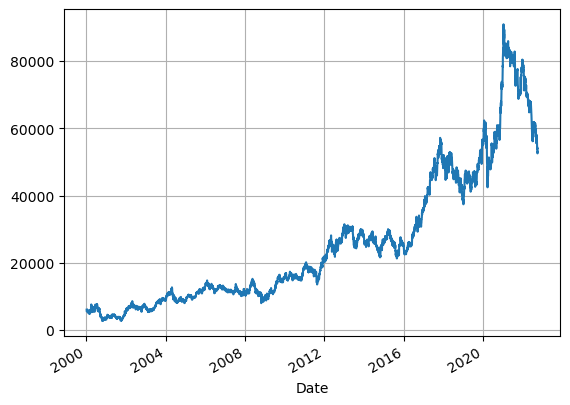

In [4]:
df.Close.plot(grid=True)

In [5]:
"""
open 시가
high 고가
low 저가
close 종가
volume 거래량
Adj Close 주식의 분할, 배당, 배분 등을 고려해 조정한 종가

Y : Adj Close
"""

X = df.drop(columns='Volume')
y = df.iloc[:, 5:6]

print(X)
print(y)

               High      Low     Open    Close     Adj Close
Date                                                        
2000-01-04   6110.0   5660.0   6000.0   6110.0   4623.468262
2000-01-05   6060.0   5520.0   5800.0   5580.0   4222.413574
2000-01-06   5780.0   5580.0   5750.0   5620.0   4252.681641
2000-01-07   5670.0   5360.0   5560.0   5540.0   4192.144531
2000-01-10   5770.0   5580.0   5600.0   5770.0   4366.187500
...             ...      ...      ...      ...           ...
2022-09-26  54200.0  53600.0  53700.0  53900.0  53900.000000
2022-09-27  54200.0  53500.0  53800.0  54200.0  54200.000000
2022-09-28  54400.0  52500.0  53900.0  52900.0  52900.000000
2022-09-29  53700.0  52600.0  53300.0  52600.0  52600.000000
2022-09-30  53600.0  51800.0  52300.0  53100.0  53100.000000

[5710 rows x 5 columns]
               Adj Close
Date                    
2000-01-04   4623.468262
2000-01-05   4222.413574
2000-01-06   4252.681641
2000-01-07   4192.144531
2000-01-10   4366.187500
...    

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

# Train Data
X_train = X_ss[:4500, :]
X_test = X_ss[4500:, :]

# Test Data
y_train = y_mm[:4500, :]
y_test = y_mm[4500:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (4500, 5) (4500, 1)
Testing Shape (1210, 5) (1210, 1)


In [7]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([4500, 1, 5]) torch.Size([4500, 1])
Testing Shape torch.Size([1210, 1, 5]) torch.Size([1210, 1])


In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='3'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))

NVIDIA RTX A5000


In [9]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
                            input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True
                            )
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)

        return out

In [15]:
num_epochs = 30000
learning_rate = 0.00001

input_size = 5
hidden_size = 5
num_layers = 1

num_classes = 1

In [16]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [17]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final.to(device))
    optimizer.zero_grad()

    loss = loss_function(outputs, y_train_tensors.to(device))
    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.04865
Epoch: 100, loss: 0.04267
Epoch: 200, loss: 0.03737
Epoch: 300, loss: 0.03272
Epoch: 400, loss: 0.02865
Epoch: 500, loss: 0.02511
Epoch: 600, loss: 0.02207
Epoch: 700, loss: 0.01946
Epoch: 800, loss: 0.01725
Epoch: 900, loss: 0.01539
Epoch: 1000, loss: 0.01383
Epoch: 1100, loss: 0.01253
Epoch: 1200, loss: 0.01145
Epoch: 1300, loss: 0.01057
Epoch: 1400, loss: 0.00983
Epoch: 1500, loss: 0.00923
Epoch: 1600, loss: 0.00874
Epoch: 1700, loss: 0.00833
Epoch: 1800, loss: 0.00799
Epoch: 1900, loss: 0.00770
Epoch: 2000, loss: 0.00746
Epoch: 2100, loss: 0.00723
Epoch: 2200, loss: 0.00704
Epoch: 2300, loss: 0.00685
Epoch: 2400, loss: 0.00669
Epoch: 2500, loss: 0.00652
Epoch: 2600, loss: 0.00636
Epoch: 2700, loss: 0.00620
Epoch: 2800, loss: 0.00603
Epoch: 2900, loss: 0.00587
Epoch: 3000, loss: 0.00571
Epoch: 3100, loss: 0.00555
Epoch: 3200, loss: 0.00539
Epoch: 3300, loss: 0.00522
Epoch: 3400, loss: 0.00506
Epoch: 3500, loss: 0.00490
Epoch: 3600, loss: 0.00473
Epoch: 3700, 

In [18]:
df_X_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(df.iloc[:, 5:6])

df_X_ss = Variable(torch.Tensor(df_X_ss))
df_y_mm = Variable(torch.Tensor(df_y_mm))

df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

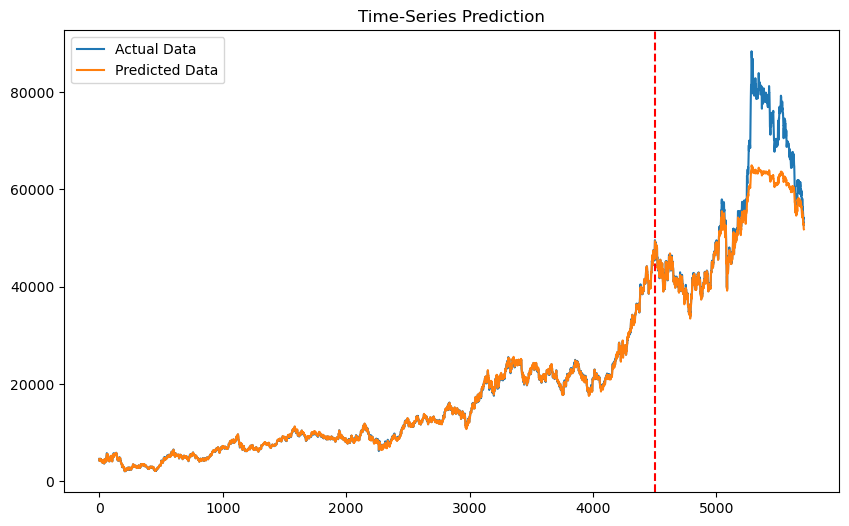

In [19]:
train_predict = lstm1(df_X_ss.to(device))
data_predict = train_predict.data.detach().cpu().numpy()
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict)
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6))
plt.axvline(x=4500, c='r', linestyle='--')

plt.plot(dataY_plot, label='Actual Data')
plt.plot(data_predict, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()